In [116]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
# from tensorflow.keras.applications.alexnet import AlexNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os


# Define constants for image resizing
IMG_SIZE_VGG_RESNET = (224, 224)  # for VGG-16, ResNet, and AlexNet
IMG_SIZE_INCEPTION = (299, 299)  # for Inception-V3
BATCH_SIZE = 2
EPOCHS = 20
N_CLASSES = 3  # We have 3 diseases

Found 142 images belonging to 3 classes.
Found 35 images belonging to 3 classes.
Found 177 images belonging to 3 classes.


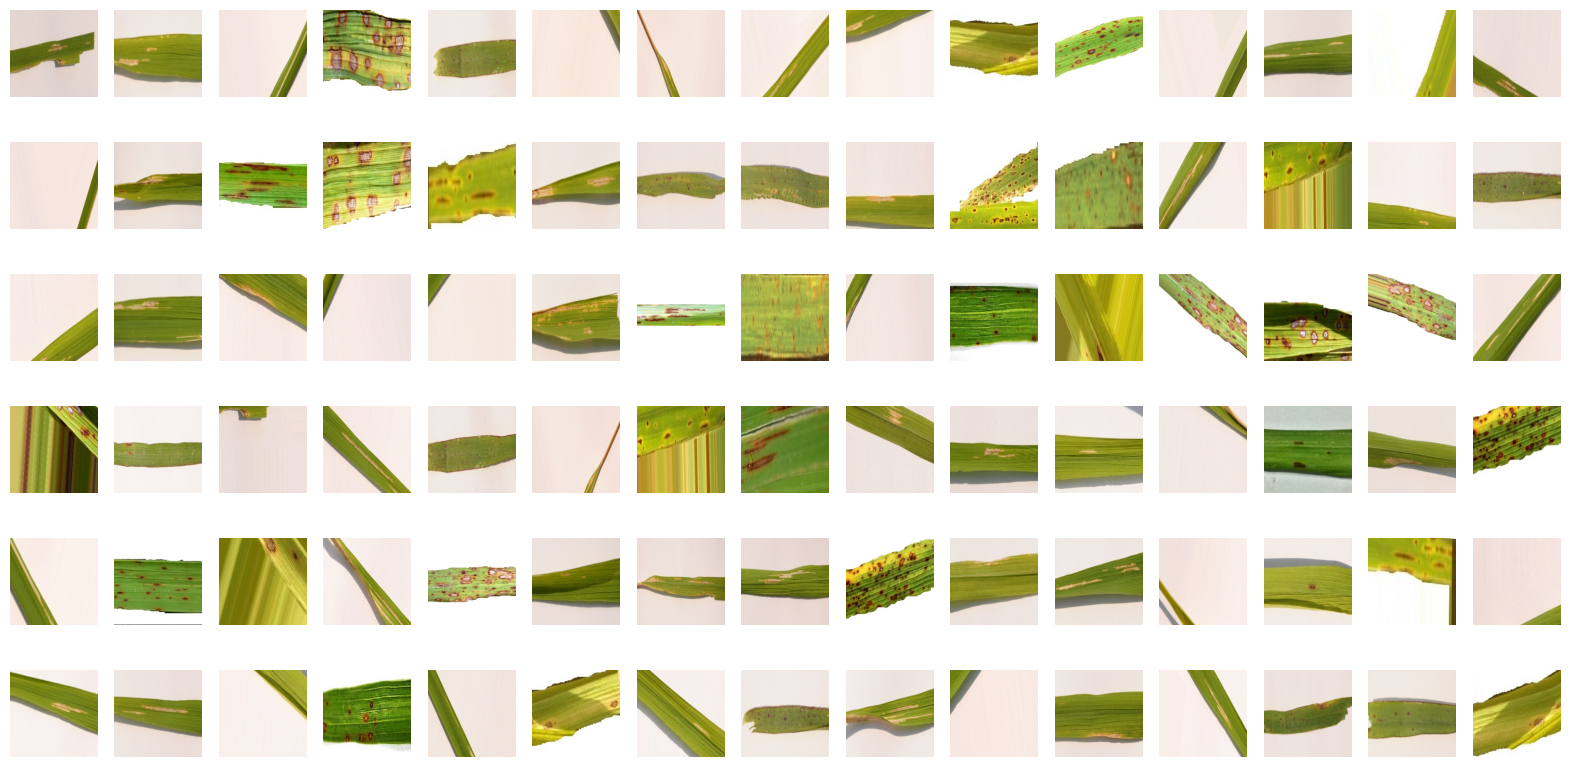

In [117]:
# Image data augmentation and preprocessing for VGG-16, ResNet, AlexNet
# datagen_aug = ImageDataGenerator(
#     horizontal_flip=True,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     fill_mode='nearest'
# )

# Temp - remove
# Path to Class 3 images
# class_3_dir = './data/Bacterial leaf blight'  # Replace with the actual path to your Class 3 images
# save_dir = './data/Bacterial leaf blight'  # Directory to save augmented images

# # Make sure the save directory exists
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Iterate over each image in Class 3
# for img_file in os.listdir(class_3_dir):
#     img_path = os.path.join(class_3_dir, img_file)
#     img = load_img(img_path)  # Load image
#     x = img_to_array(img)  # Convert image to NumPy array
#     x = x.reshape((1,) + x.shape)  # Reshape the array for ImageDataGenerator

#     # Generate and save augmented images
#     i = 0
#     for batch in datagen_aug.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpeg'):
#         i += 1
#         if i > 1:  # Generate 1 augmented images per original image
#             break  # Stop after generating 10 images


datagen_vgg_resnet = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Split the data into training and validation sets
)

# # Image data augmentation and preprocessing for Inception-V3
# datagen_inception = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2
# )

# Load and resize images for VGG-16, ResNet, and AlexNet
train_generator_vgg_resnet = datagen_vgg_resnet.flow_from_directory(
    './data',
    target_size=IMG_SIZE_VGG_RESNET,  # Resize to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator_vgg_resnet = datagen_vgg_resnet.flow_from_directory(
    './data',
    target_size=IMG_SIZE_VGG_RESNET,  # Resize to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


train_generator_vgg_resnet_display = datagen_vgg_resnet.flow_from_directory(
    './data',
    target_size=IMG_SIZE_VGG_RESNET,  # Resize to 224x224
    batch_size=1,
    class_mode=None
)


# Display augmented images from the directory
fig, ax = plt.subplots(6, 15, figsize=(20, 10))

for i in range(90):
    aug_img = next(train_generator_vgg_resnet_display)[0]  # Get the first image from the batch
    ax[i//15, i%15].imshow(aug_img)       # Display in grid
    ax[i//15, i%15].axis('off')           # Turn off axis

plt.show()



# Load and resize images for Inception-V3 (requires 299x299)
# train_generator_inception = datagen_inception.flow_from_directory(
#     './data',
#     target_size=IMG_SIZE_INCEPTION,  # Resize to 299x299
#     batch_size=16,
#     class_mode='categorical',
#     subset='training'
# )

# val_generator_inception = datagen_inception.flow_from_directory(
#     './data',
#     target_size=IMG_SIZE_INCEPTION,  # Resize to 299x299
#     batch_size=16,
#     class_mode='categorical',
#     subset='validation'
# )


In [118]:
# Function to create and compile model
def build_model(base_model, base_name):
    base_model.trainable = False  # Freeze the convolutional base
# Freeze the base layers of the pre-trained model
    # for layer in base_model.layers:
    #     layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add regularization with dropout
    predictions = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    loss_fn = CategoricalCrossentropy()
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss=loss_fn,
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


In [119]:
# Model building functions for VGG16, AlexNet, ResNet, InceptionV3
models = {
    'VGG-16': build_model(VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE_VGG_RESNET + (3,)), 'VGG-16')
    # 'AlexNet': build_model(AlexNet(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)), 'AlexNet'),
    # 'Inception-V3': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE_INCEPTION + (3,)), 'Inception-V3'),
    # 'ResNet': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE_VGG_RESNET + (3,)), 'ResNet')
}


In [120]:
# Train and evaluate each model
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor ('val_accuracy', 'val_loss', etc.)
    patience=5,               # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore the weights of the best epoch once training stops
)

results = {}

for name, model in models.items():
    print(f'Training {name}...')
    history = model.fit(train_generator_vgg_resnet, epochs=EPOCHS, validation_data=val_generator_vgg_resnet)
    print(f'Metric names ')
    print(model.metrics_names, sep = ", ")
    # Evaluate the model on validation set
    val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator_vgg_resnet)
    
    # Convert predictions to labels
    val_preds = model.predict(val_generator_vgg_resnet)
    val_preds = np.argmax(val_preds, axis=1)
    val_labels = val_generator_vgg_resnet.classes
    
    # Generate classification report
    report = classification_report(val_labels, val_preds, output_dict=True)
    
    # Store the metrics
    results[name] = {
        'accuracy': val_accuracy,
        'f1_score': report['weighted avg']['f1-score'],
        'precision': val_precision,
        'recall': val_recall
    }

# Print initial results in tabular form
print("Model Name\tAccuracy\tF-1 Score\tRecall\tPrecision")
for name, metrics in results.items():
    print(f"{name}\t{metrics['accuracy']:.4f}\t{metrics['f1_score']:.4f}\t{metrics['recall']:.4f}\t{metrics['precision']:.4f}")



Training VGG-16...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.4227 - loss: 1.0970 - precision_23: 0.3801 - recall_23: 0.2189 - val_accuracy: 0.5143 - val_loss: 1.0268 - val_precision_23: 0.4444 - val_recall_23: 0.2286
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.4287 - loss: 1.0814 - precision_23: 0.4976 - recall_23: 0.2367 - val_accuracy: 0.5143 - val_loss: 1.0251 - val_precision_23: 0.4444 - val_recall_23: 0.2286
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.3545 - loss: 1.2529 - precision_23: 0.3062 - recall_23: 0.1533 - val_accuracy: 0.5143 - val_loss: 1.0227 - val_precision_23: 0.4444 - val_recall_23: 0.2286
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.3519 - loss: 1.2426 - precision_23: 0.3813 - recall_23: 0.2079 - val_accuracy: 0.5143 - val_loss: 1.0209 - val_precision_23: 0.4706 - val_recall_23: 0.2286
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.4505 - loss: 1.1519 - 

D:\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


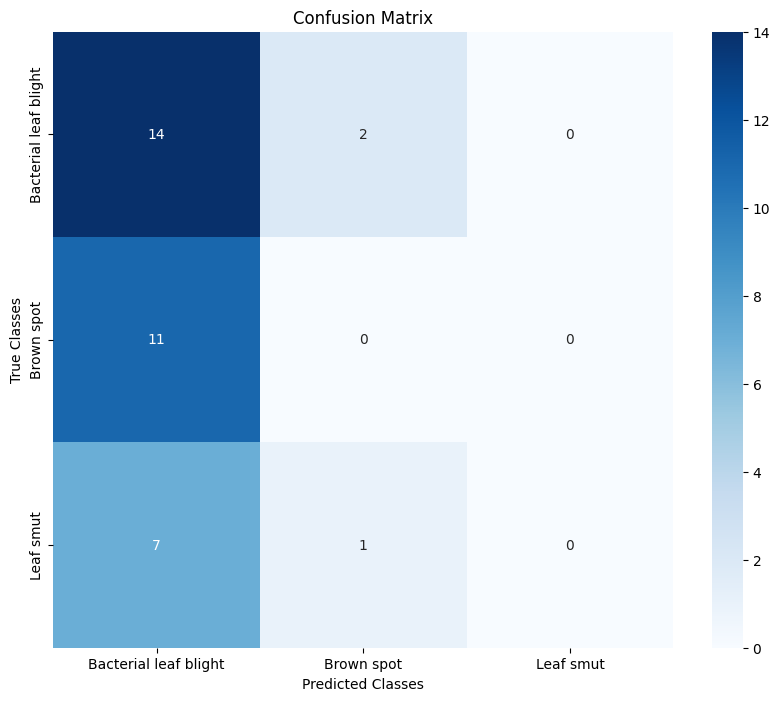

Correct predictions 14
Total predictions 35
Accuracy: 40.00%


In [121]:

import numpy as np

# Make predictions on the validation dataset
val_steps = int(np.ceil(val_generator_vgg_resnet.samples / val_generator_vgg_resnet.batch_size))  # Total steps for validation
predictions = model.predict(val_generator_vgg_resnet, steps=val_steps)  # Get predicted probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get the true labels from the validation generator
true_classes = val_generator_vgg_resnet.classes  # True labels
class_labels = list(val_generator_vgg_resnet.class_indices.keys())  # Get class labels

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix
confusion_mtx = confusion_matrix(val_generator_vgg_resnet.classes, val_preds)  
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

correct_predictions = np.sum(predicted_classes == true_classes)  # Count correct predictions
total_predictions = len(true_classes)  # Total number of predictions
print('Correct predictions ' + str(correct_predictions))
print('Total predictions ' + str(total_predictions))
accuracy = correct_predictions / total_predictions  # Calculate accuracy
print(f'Accuracy: {accuracy * 100:.2f}%') 

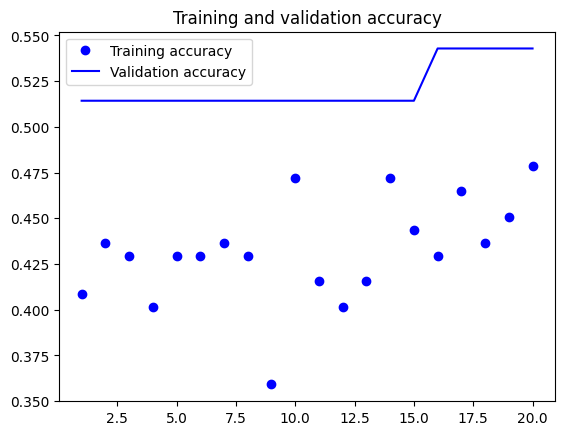

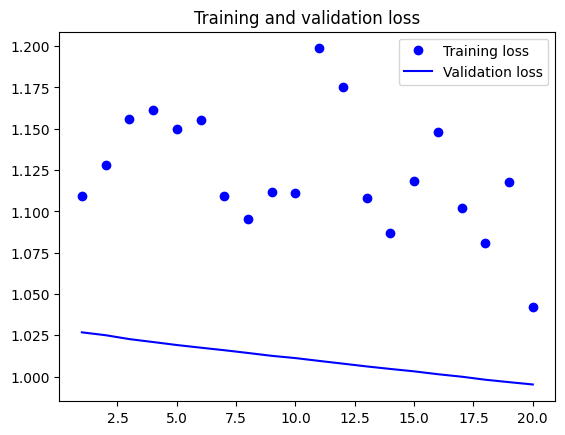

In [122]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()